<a href="https://colab.research.google.com/github/ClementBM/Experiment_DeepLearning_Moonboard_Grade-Prediction/blob/master/LSTM_BoulderProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import some relevant packages

In [1]:
from sklearn.utils import shuffle
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

from climbing_ai.moonboard_dataset import MoonboardDataset, data_preprocessing, extract_batch
from climbing_ai.moonboard_tokenizer import MoonboardTokenizer
from climbing_ai.moonboard_evaluation import evaluate

N_LAYERS = 3
ATTN_HEADS = 6 # 32 * 4 = 128
DROPOUT = 0.1
EMBED_DIM = 60

IGNORE_INDEX = -100

EVAL_ITERS = 10
MAX_ITERS = 10000
EVAL_INTERVAL = 1000
LEARNING_RATE = 1e-4
EPOCHS = 600

BATCH_SIZE = 64 # how many independent sequences will we process in parallel?

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load and parse data
I scrapped little bits of data from the moonboard official website (hoped they don't bother.. ). The data is formatted as json files. Each file is named with the grade difficulty. In this step, I also calculate the distance between holds.

In [2]:
dataset = data_preprocessing()
shuffled_dataset = shuffle(dataset, random_state=42)

max_len = max([len(data["holds"]) for data in dataset]) + 2

# Keep 90% for training, 10% for validation
split = int(0.9 * len(dataset))

train_ds = shuffled_dataset[:split]
eval_ds = shuffled_dataset[split:]

tokenizer = MoonboardTokenizer(
    horizontal_count=11,
    vertical_count=18,
    horizontal_spacing=50,
    vertical_spacing=50,
)

train_dataset = MoonboardDataset(
    dataset=train_ds, tokenizer=tokenizer, max_len=max_len
)
eval_dataset = MoonboardDataset(
    dataset=eval_ds, tokenizer=tokenizer, max_len=max_len
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=True)

# Look at the data
Just a brief look at the data. We have distances - numerical data - and hold names - categorical data. In the following parts we use the one-hot vectors created from hold names. We add the numerical to the one-hot vector, ugly method waiting for a way to combine numerical and categorical variables in neural network.

In [3]:
eval_dataset[9]

{'input_ids': tensor([  0,  72, 101, 112, 114, 140, 189, 200, 201, 201, 201, 201, 201, 201,
         201, 201]),
 'input_locations': tensor([[-100, -100],
         [ 150,  850],
         [ 250,  500],
         [ 300,  150],
         [ 300,  250],
         [-100, -100],
         [ 500,  400],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100],
         [-100, -100]]),
 'masked_input_ids': tensor([  0,  72, 101, 112, 114, 199, 189, 200, 201, 201, 201, 201, 201, 201,
         201, 201]),
 'masked_token_ids': tensor([ 140, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100]),
 'masked_positions': tensor([5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 'grade_id': tensor(10)}

# Building the model

In [4]:
from climbing_ai.wolfbert_simple import WolfBERT


model = WolfBERT(
    vocab_size=tokenizer.get_vocab_size(),
    embed_dim=EMBED_DIM,
    num_heads=ATTN_HEADS,
    dropout=DROPOUT,
    classifier_count=len(MoonboardDataset.grades)
)
m = model.to(DEVICE)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# `ignore_index`: specifies a target value that is ignored
# and does not contribute to the input gradient. When :attr:`size_average` is
# `True`, the loss is averaged over non-ignored targets. Note that
# Only applicable when the target contains class indices

loss_fn_lm = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
loss_fn_clsf = torch.nn.CrossEntropyLoss() 

# Training loop

In [5]:
epoch_iterator = tqdm(range(10))
model.train()

for epoch in epoch_iterator:
    for batch in train_dataloader:
        (
            input_ids,
            input_locations,
            masked_input_ids,
            masked_token_ids,
            masked_positions,
            attention_mask,
            grade_id,
            sequence_length,
        ) = extract_batch(batch, DEVICE)

        # evaluate the loss
        logits_lm, logits_clsf = model(masked_input_ids,
                                       attention_mask,
                                       masked_positions)
        
        loss_lm = loss_fn_lm(logits_lm.transpose(-2,-1), masked_token_ids) # for masked LM
        loss_clsf = loss_fn_clsf(logits_clsf, grade_id) # for sentence classification
        loss = loss_lm + loss_clsf
        
        epoch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Processing Epoch 00: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s, loss=7.347]


# Test time

In [6]:
from random import randint


test_batch = train_dataset[randint(0,100)]

input_ids = test_batch['input_ids'].unsqueeze(0).to(DEVICE)
input_locations = test_batch['input_locations'].unsqueeze(0).to(DEVICE)
masked_input_ids = test_batch['masked_input_ids'].unsqueeze(0).to(DEVICE)
masked_token_ids = test_batch['masked_token_ids'].unsqueeze(0).to(DEVICE)
masked_positions = test_batch['masked_positions'].unsqueeze(0).to(DEVICE)
attention_mask = test_batch['attention_mask'].unsqueeze(0).to(DEVICE)

model.eval()
logits_lm, logits_clsf = model(masked_input_ids,
                               attention_mask,
                               masked_positions)
model.train()

print(tokenizer.decode(masked_input_ids.cpu().squeeze().numpy()))
print(tokenizer.decode(input_ids.cpu().squeeze().numpy()))

display(tokenizer.decode(torch.argmax(logits_lm[0], dim=1).cpu().squeeze().numpy())[0])

display(torch.argmax(logits_clsf))
display(test_batch["grade_id"])

['[CLS]', 'B6', 'C3', 'C12', 'G9', 'G15', '[MASK]', '[EOB]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'B6', 'C3', 'C12', 'G9', 'G15', 'H18', '[EOB]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


'H18'

tensor(5, device='cuda:0')

tensor(8)

# Evaluate
* We make predictions on the test set rounding the predicted grade floating number.
* We then calculate the related MAE based on these prediction.
* The grade error is shown in the heat map.
* The absolute error is shown in the histogram.

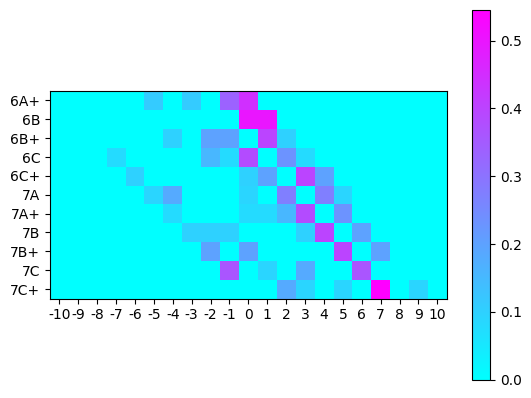

MAE = 2.825688123703003
Correctness Count = {0} : [14.68%] + {1} : [20.18%] = 34.86%
First Bound Grade Error Count = {2} : [15.6%] + {3} : [14.68%] = 30.28%
Second Bound Grade Error Count = {4} : [11.93%] + {5} : [8.26%] + {6} : [6.42%] = 26.61%


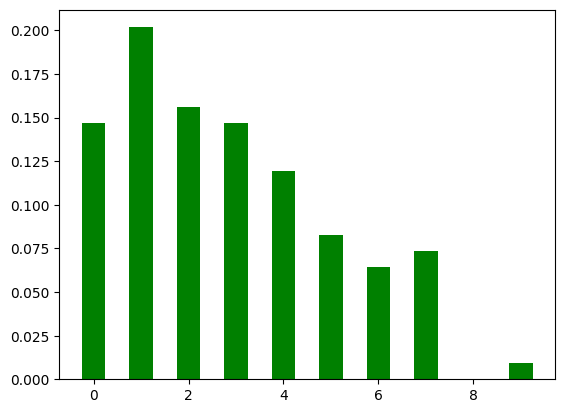

In [7]:
def call_model(compressed_batch, model):
    (
        input_ids,
        input_locations,
        masked_input_ids,
        masked_token_ids,
        masked_positions,
        attention_mask,
        grade_id,
        sequence_length,
    ) = compressed_batch

    logits_lm, logits_clsf = model(
        masked_input_ids,
        attention_mask,
        masked_positions
    )
    return logits_clsf

evaluate(model=model,
         call_model=call_model,
         dataloader=eval_dataloader,
         device=DEVICE)